In [39]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
import warnings
warnings.filterwarnings("ignore")

# Time series project

## Project description

The dataset harvard_fees.csv contains the yearly total cost of
studying at Harvard university, Cambridge, Massachussets, USA from
1985 to 2016. Make a time series model of this data with the aim of
forecasting the cost of the next few years (2017-2023). Compare you
forecast with the real cost that you can find at the website https:
//oira.harvard.edu/factbook/fact-book-ug-tuition/

## Data exploration 

First we import the files (the online file has already been converted to csv for convenience):

In [40]:
fees = pd.read_csv("harvard_fees.csv").iloc[:,1:].iloc[::-1].reset_index(drop=True)
fees_to_predict =  pd.read_csv("harvard_fees_to_predict.csv").iloc[::-1].reset_index(drop=True)

We can see that there are many colums, but we only need to explore the 'Academic.Year' and 'Total....' colums:

In [41]:
fees.columns

Index(['Academic.Year', 'Tuition....', 'Health.Services.Fee....',
       'Student.Services.Fee....', 'Room....', 'Board....', 'Total....'],
      dtype='object')

### The dataset

In [42]:
fees[['Academic.Year','Total....']].head()

,Academic.Year,Total....
0,1985,14100
1,1986,15100
2,1987,16145
3,1988,17100
4,1989,18210


First we look at the fees over the years. We can observe that the trend is fairly linear, with the exception of a "bump" in the middle:

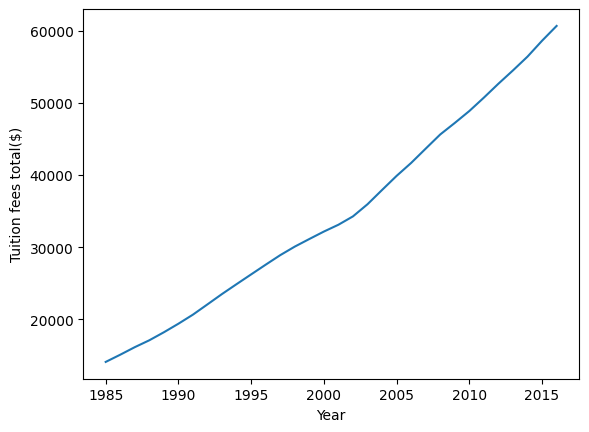

In [43]:
plt.plot(np.array(fees['Academic.Year']),np.array(fees['Total....']))
plt.xlabel("Year")
plt.ylabel("Tuition fees total($)")

plt.show()

We can also look at the autocorrelation plot (the dashed line is 99% confidence band). As we can see, up to lag=5 we are above the 99% confidence line:

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

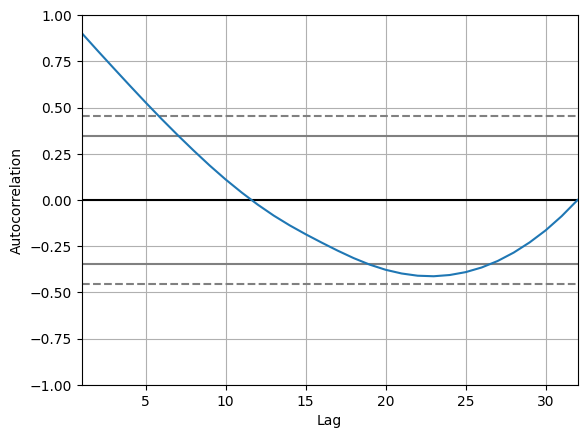

In [44]:
autocorrelation_plot(fees['Total....'])

## Modeling

The modelling will be done by trying the following: linear regression, linear regression + ARIMA, just ARIMA. First we will train the models and see all the results together for comparison.

### Linear regression

Let's first try linear regression as a baseline. We will be using the same linear regression model in two ways. One is standalone (as a baseline) and one is in conjunction with an ARIMA model:

In [45]:
lr = LinearRegression()

In [46]:
lr.fit(np.array(fees['Academic.Year']).reshape(-1,1),fees['Total....'])
pass

### Linear regression + ARIMA

Since the data above does not look stationary, we can try and subract from it the linear model's results and see what's left. We can observe that the remaining data still does not look stationary, but we can still try to model it as an ARIMA process, with the "integration" parameter well set:

In [47]:
differemces_with_lr = np.array(fees['Total....']) - lr.predict(np.array(fees['Academic.Year']).reshape(-1,1))

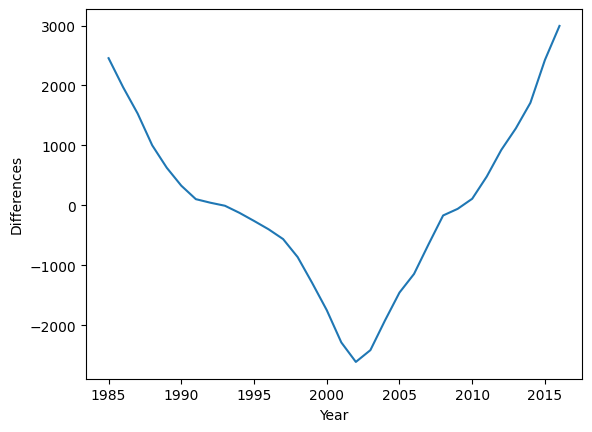

In [48]:
plt.plot(np.array(fees['Academic.Year']),differemces_with_lr)
plt.xlabel("Year")
plt.ylabel("Differences")

plt.show()

We can also plot the autocorellation of the graph above and we can see that there is still significant autocorrelation present:

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

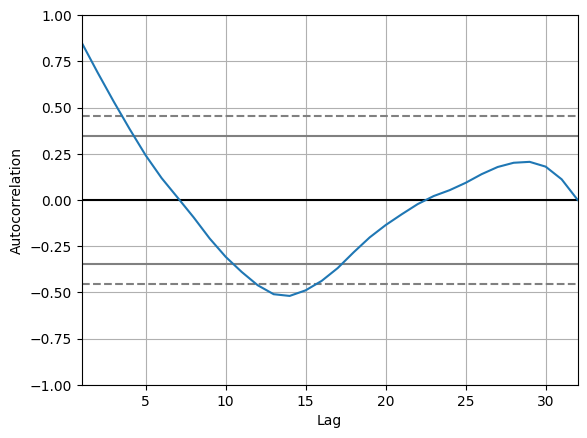

In [49]:
autocorrelation_plot(differemces_with_lr)

As stated above, we will model both the original data and the differences data with ARIMA (the first for "pure ARIMA" and the second for "linear model + ARIMA"). In order to chose the best model we can grid search trough the diffent combinations of the three parameters, using one of the information criteria as our metric for chosing the best model. In this case the AIC metric (lower = better) has been chosen:

In [50]:
param_grid_sup_arima ={'ar': [0, 1,2,3,4,5],"i":[0,1,2], 'ma': [0, 1,2,3,4,5]}
 

In [51]:
def grid_search_arima(series, param_grid):    
    best_model = None
    best_score = 9999999999
    best_params = None
    for ar in param_grid["ar"]:
        for i in param_grid["i"]:
            for ma in param_grid["ma"]:
                arima_model = ARIMA(series, order=(ar,i,ma))
                arima_model_fit = arima_model.fit()
                if arima_model_fit.aic < best_score:
                    best_score = arima_model_fit.aic
                    best_model = arima_model_fit
                    best_params = (ar,i,ma)
    return best_model, best_score, best_params

We start by applying the gridsearch to the differences:

In [52]:
best_model_sup_arima, best_score_sup_arima, best_params_sup_arima = grid_search_arima(differemces_with_lr,param_grid_sup_arima)

Here we can see the chosen parameters (ARIMA(1, 2, 3)) and the scores (AIC = 388.609):

In [53]:
print(best_model_sup_arima.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:                 ARIMA(1, 2, 3)   Log Likelihood                -189.305
Date:                Thu, 01 Feb 2024   AIC                            388.609
Time:                        21:00:27   BIC                            395.615
Sample:                             0   HQIC                           390.850
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4334      0.436     -0.994      0.320      -1.288       0.421
ma.L1          1.4332      2.459      0.583      0.560      -3.386       6.253
ma.L2         -0.0503      1.414     -0.036      0.9

We can also observe that i=2 has been chosen as a parameter; visually we can inspect the difference array of the data the ARIMA model was given (difference array of the differences with the linear model) and plot the two orders of magnitude. Indeed the i=2 looks like the stationary series:

i=1

In [54]:
#best_model_sup_arima = ARIMA(differemces_with_lr, order=(0, 2, 2)).fit()

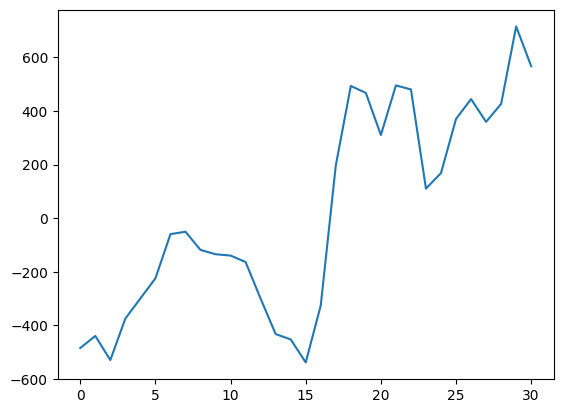

In [55]:
plt.plot(np.diff(differemces_with_lr, n=1))

i=2

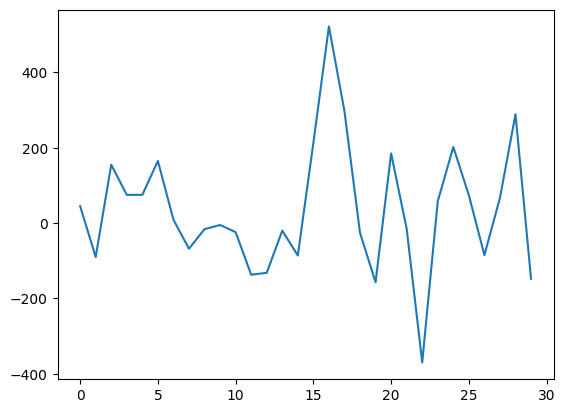

In [56]:
plt.plot(np.diff(differemces_with_lr, n=2))

We can see how the model predicts the data and we can see that it is very accurate:

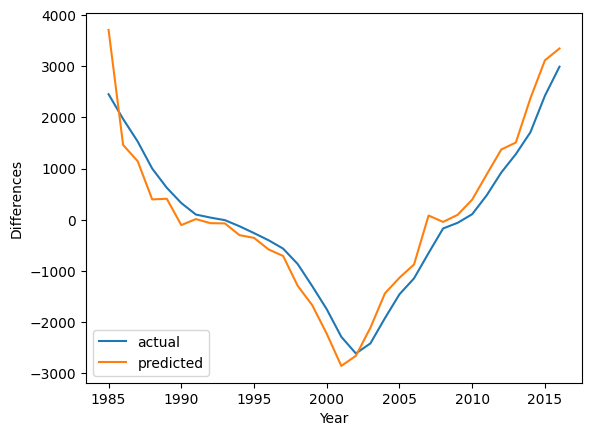

In [57]:
plt.plot(np.array(fees['Academic.Year']),differemces_with_lr, label="actual")
plt.plot(np.array(fees['Academic.Year']),best_model_sup_arima.predict(1,len(fees['Academic.Year'])), label="predicted")
plt.xlabel("Year")
plt.ylabel("Differences")
plt.legend()
plt.show()

### Pure ARIMA

Now we can try gridsearch in order to train the ARIMA model directly on the original data. The only difference here is that the "i" parameter ("Integrated") is never set to 0 since it is expected that at least 1 degree is necessary:

In [58]:
fused_predictions = lr.predict(np.array(fees['Academic.Year']).reshape(-1,1))+best_model_sup_arima.predict(1,len(fees['Academic.Year']))

In [59]:
param_grid_pure_arima ={'ar':  [0, 1,2,3,4,5],"i":[1,2], 'ma':  [0, 1,2,3,4,5]}

In [60]:
best_model_pure_arima, best_score_pure_arima, best_params_pure_arima = grid_search_arima(fees['Total....'],param_grid_pure_arima)

Here we can see that the ARIMA(0, 2, 2) model is chosen with AIC = 392.583:

In [61]:
print(best_model_pure_arima.summary())

                               SARIMAX Results                                
Dep. Variable:              Total....   No. Observations:                   32
Model:                 ARIMA(0, 2, 2)   Log Likelihood                -193.291
Date:                Thu, 01 Feb 2024   AIC                            392.583
Time:                        21:00:46   BIC                            396.786
Sample:                             0   HQIC                           393.928
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6083      0.254      2.390      0.017       0.110       1.107
ma.L2         -0.3502      0.224     -1.560      0.119      -0.790       0.090
sigma2       1.79e+04   5705.920      3.137      0.0

We can observe that, again, i=2 has been chosen as a parameter; visually we can inspect the "difference array" of the orignal data and see the two orders of magnitude. Indeed the i=2 looks, again, like a stationary series:

Note: the graphs are almost identical to the ones above, even though the starting data is shaped completely differently. The possible explanation for why this happens is that subracting from the data the linear regression of said data the proportion of the distances among individual points. We will see later how this affects the final result.

i=1

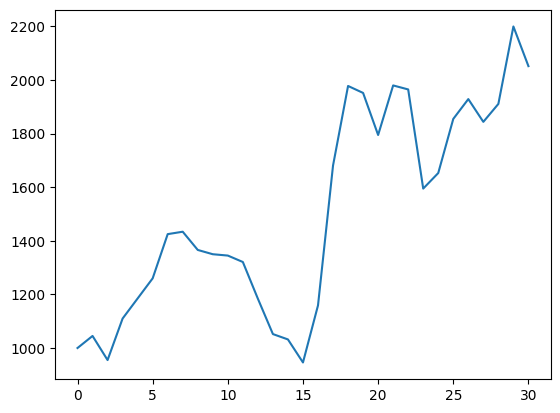

In [62]:
plt.plot(np.diff(np.array(fees['Total....']), n=1))

i=2

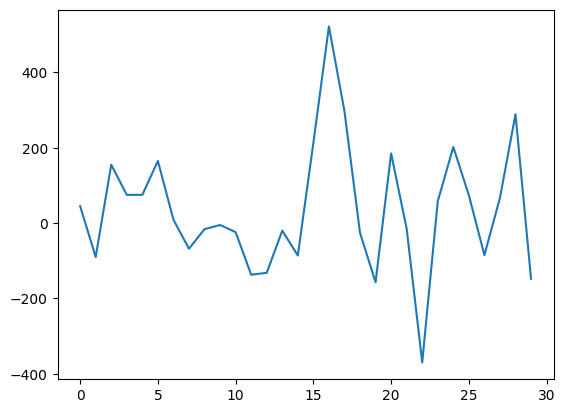

In [63]:
plt.plot(np.diff(np.array(fees['Total....']), n=2))

### Comparisons

Here we compare all the methods with the "training" data. Everithing looks very close to the original, but predicting the new data will be the real test:

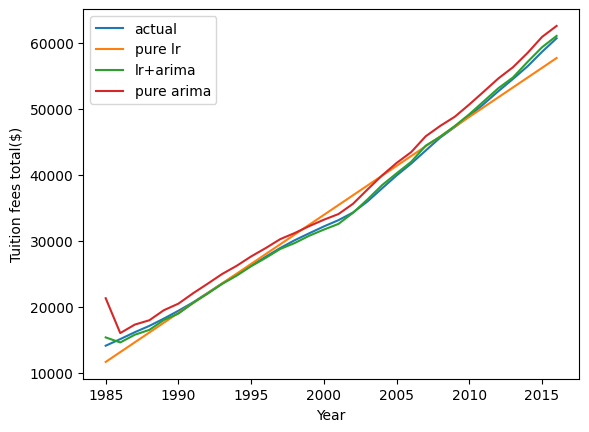

In [64]:
plt.plot(np.array(fees['Academic.Year']),np.array(fees['Total....']), label='actual')
plt.plot(np.array(fees['Academic.Year']),lr.predict(np.array(fees['Academic.Year']).reshape(-1,1)), label='pure lr')
plt.plot(np.array(fees['Academic.Year']),fused_predictions, label='lr+arima')
plt.plot(np.array(fees['Academic.Year']),best_model_pure_arima.predict(1,len(fees['Academic.Year'])), label='pure arima')
plt.xlabel("Year")
plt.ylabel("Tuition fees total($)")
plt.legend()
plt.show()

## Prediction

### Prediction dataset

In [65]:
fees_to_predict.head()

,year,total
0,2017,63025
1,2018,65609
2,2019,67580
3,2020,69607
4,2021,72357


Here we can plot the new data and see how it compares to the old one. The trend appears to continue in a predictable way:

Note: there is no actual gap in the years

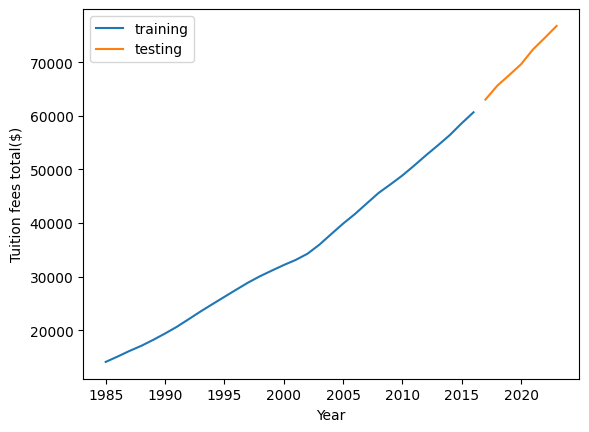

In [66]:
plt.plot(np.array(fees['Academic.Year']),np.array(fees['Total....']), label="training")
plt.plot(fees_to_predict["year"],np.array(fees_to_predict["total"]), label="testing")
plt.xlabel("Year")
plt.ylabel("Tuition fees total($)")
plt.legend()
plt.show()

### Loss

In order to see which model yields the best results, we can define a loss function; here the one chosen is the MSE:

In [67]:
loss = lambda Y, Y_pred : sum((Y-Y_pred)**2)/len(Y_pred)

We can first obeserve the loss of the linear model:

In [68]:
loss(fees_to_predict["total"], lr.predict(np.array(fees_to_predict["year"]).reshape(-1,1)))

42502924.12161088

Next we can obeserve the loss of the linear model + the ARIMA model, which has perfomed better than the pure linear model:

In [69]:
loss(fees_to_predict["total"],  lr.predict(np.array(fees_to_predict["year"]).reshape(-1,1))+best_model_sup_arima.forecast(len(fees_to_predict["year"])))

3165246.024207198

Finally we can see the pure ARIMA model, which appears to be the best performer:

In [70]:
loss(fees_to_predict["total"], np.array(best_model_pure_arima.forecast(len(fees_to_predict["year"]))))

2990137.386470183

We can confirm grafically what we observed with the loss; it might appear that there is a glitch in the graph, since "pure arima" seems to be missing, but in reality it just overlaps very much with the "lr + arima" one:

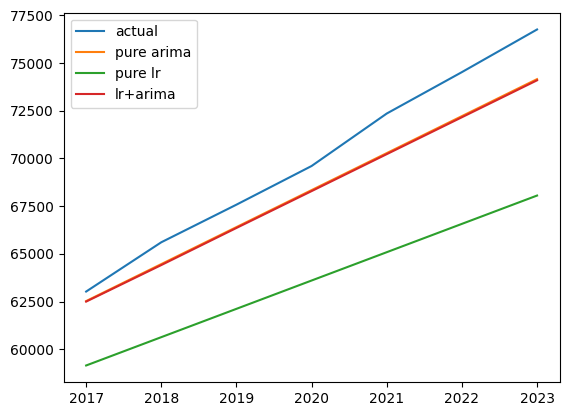

In [71]:
lr_and_arima=  lr.predict(np.array(fees_to_predict["year"]).reshape(-1,1))+best_model_sup_arima.forecast(len(fees_to_predict["year"]))
plt.plot(fees_to_predict["year"],fees_to_predict["total"], label='actual')
plt.plot(fees_to_predict["year"],best_model_pure_arima.forecast(len(fees_to_predict["year"])), label='pure arima')
plt.plot(fees_to_predict["year"],lr.predict(np.array(fees_to_predict["year"]).reshape(-1,1)), label="pure lr")
plt.plot(fees_to_predict["year"],lr_and_arima, label="lr+arima")
plt.legend()
plt.show()

Here we can see that they are indeed so similar that they almost completely overlap. We could still observe that they are slightly different based on the different losses:

Note: the data on which the two ARIMA models have been trained on has the same autoregressive characteristics, so this might be an explanation of the results. There is stil a notable difference and is not due to the different parameters of the ARIMA models; two models with the same parameters have been tested.

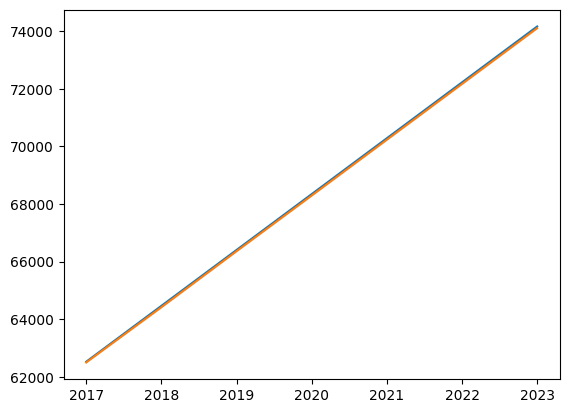

In [72]:
plt.plot(fees_to_predict["year"],best_model_pure_arima.forecast(len(fees_to_predict["year"])), label='pure arima')
plt.plot(fees_to_predict["year"],lr_and_arima, label="lr+arima")


### Extra analysis of Linear regression + ARIMA

Looking at the **data - linear_model_predictions** on the initial data ("training") and on the new data "testing" reveals that the increasing trend seen by the arima model has been continuing, aiding the prediction accuracy:

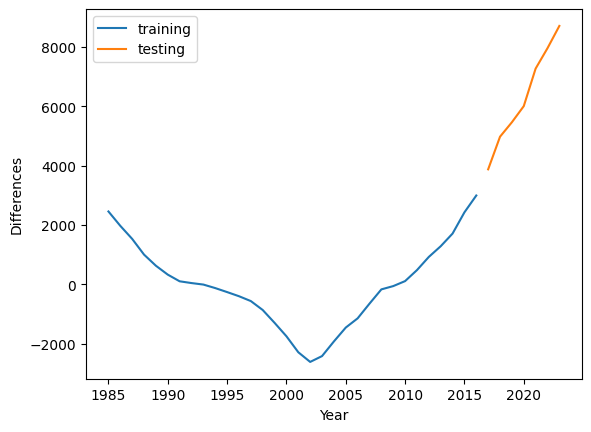

In [73]:
plt.plot(np.array(fees['Academic.Year']),differemces_with_lr, label="training")
plt.plot(fees_to_predict["year"], fees_to_predict["total"] - lr.predict(np.array(fees_to_predict["year"]).reshape(-1,1)), label="testing")

plt.xlabel("Year")
plt.ylabel("Differences")
plt.legend()
plt.show()

We can also observe the inflection point by comparing the whole data and the linear model prediction and see which part the "extra" ARIMA model helped correcting:

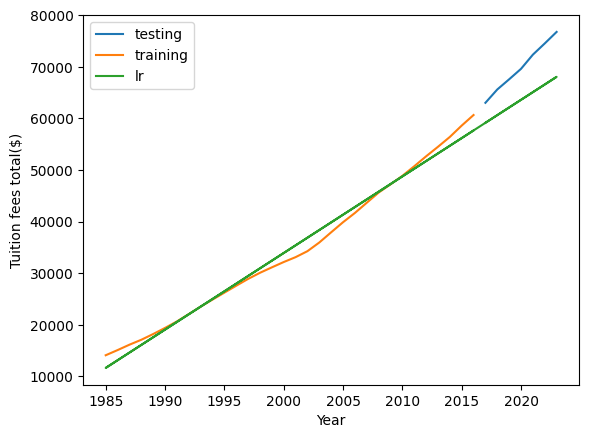

In [74]:
plt.plot(fees_to_predict["year"],np.array(fees_to_predict["total"]), label="testing")
plt.plot(np.array(fees['Academic.Year']),np.array(fees['Total....']), label="training")
plt.plot(list(fees_to_predict["year"])+ list(np.array(fees['Academic.Year'])),lr.predict(np.array(list(fees_to_predict["year"])+ list(np.array(fees['Academic.Year']))).reshape(-1,1)), label="lr")

plt.xlabel("Year")
plt.ylabel("Tuition fees total($)")
plt.legend()
plt.show()